<a href="https://colab.research.google.com/github/ppiont/tensor-flow-state/blob/master/Model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/tensor-flow-state/tensor-flow-state"

/gdrive/My Drive/tensor-flow-state/tensor-flow-state


In [0]:
import pandas as pd
df = pd.read_csv("data/df_imputed_week_shift.csv", index_col = 0, parse_dates = True)

In [0]:
# 0 resample
# 1 log transformere. 
# 2 difference ift. speed limit (som ogsaa skal vaere log transformeret)
# 3 

In [0]:
cols = ["speed", "flow", "speed_-2", "speed_-1","speed_+1", "speed_+2", "flow_-2", "flow_-1", "flow_+1", "flow_+2", "speed_limit"]
speed_cols = ["speed", "speed_-2", "speed_-1","speed_+1", "speed_+2"]
flow_cols = ["flow", "flow_-2", "flow_-1", "flow_+1", "flow_+2"]

### First resample to elmininate some noise

In [0]:
import numpy as np
def resample_df(df, freq = "10T", method_speed = np.median, method_flow = np.sum):
    copied = df.copy()
    copied = copied.resample(freq).agg({
           "speed": method_speed, "speed_-2": method_speed, "speed_-1": method_speed, "speed_+1": method_speed, "speed_+2": method_speed,
           "flow": method_flow, "flow_-2": method_flow, "flow_-1": method_flow, "flow_+1": method_flow, "flow_+2": method_flow,
           "speed_limit": np.median})
    return copied

In [0]:
r_df = resample_df(df, freq = "10T")

### Train test split. The final year is reserved for testing. (Val will be relevant later?)

In [0]:
def train_val_test_split(df, val_year, test_year):
    # train, test
    return df[(df.index.year != val_year) & (df.index.year != test_year)], df[df.index.year == val_year], df[df.index.year == test_year]

In [0]:
train, val, test = train_val_test_split(r_df, 2018, 2019)

In [0]:
import numpy as np
def log_transform(df):
    copy = df.copy()
    return np.log(copy.iloc[:, :-1].replace(0, 1e-15)).join(df.iloc[:, -1], how = 'inner')

# Log transform. First set 0s to very low value 'cause you can't log 0.
train_log = log_transform(train)
val_log = log_transform(val)

In [0]:
def calc_mean(df, col):
    # mean(100), mean(120)
    return df.groupby(['speed_limit'])[col].mean().values

def calc_sd(df, col):
    # sd(100), sd(120)
    return df.groupby(['speed_limit'])[col].std().values

def normalize_df(df, cols):
    copy = df.copy()
    for col in cols:
        # Find mean and sd for column
        mean100, mean120 = calc_mean(copy, col)
        sd100, sd120 = calc_sd(copy, col)
        copy[col] = np.where(copy.speed_limit == 100, (copy[col] - mean100) / sd100, (copy[col] - mean120) / sd120)
    return copy

In [0]:
train_norm = normalize_df(train_log, cols[:-1])
val_norm = normalize_df(val_log, cols[:-1])

In [0]:
# Generates sequential 3D batches to feed to the model
def generator(data, lookback, delay, min_index = 0, max_index = None, 
              shuffle = False, batch_size = 128, step = 1, target_col = 0):
    # If max index not given, subtract prediction horizon - 1 (len to index) from last data point
    if max_index is None:
        max_index = len(data) - delay - 1
    # Set i to first idx with valid lookback length behind it
    i = min_index + lookback
    while 1:
        # Use shuffle for non-sequential data
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size = batch_size)
        # Else for sequential (time series)
        else:
            # Check if adding batch exceeds index bounds
            if i + batch_size >= max_index:
                # Return i to beginning
                i = min_index + lookback
            # Select next valid row range
            rows = np.arange(i, min(i + batch_size, max_index))
            # Increment i
            i += len(rows)
        # Initialize sample and target arrays
        samples = np.zeros((len(rows),
                            lookback // step,
                            np.shape(data)[-1]))
        targets = np.zeros((len(rows),))
        # Generate samples, targets
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_col]
        yield samples, targets

In [0]:
# Generator 'settings'

train_data = train_norm.iloc[:, 0].values
train_data = np.reshape(train_data, (np.shape(train_data)[0], 1))
np.shape(train_data)

lookback = 3 * 6 # 3 hours
delay = 3 # 30 minutes
step = 1
batch_size = 512
min_index_train = 0
max_index_train = len(train_data)
train_gen = generator(train_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = min_index_train,
                      max_index = max_index_train,
                      step = step, 
                      batch_size = batch_size,
                      target_col = 0)


val_data = val_norm.iloc[:, 0].values
train_data = np.reshape(train_data, (np.shape(train_data)[0], 1))
np.shape(train_data)

min_index_val = 0
max_index_val= len(val_data)
val_gen = generator(val_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = min_index_val,
                      max_index = max_index_val,
                      step = step, 
                      batch_size = batch_size,
                      target_col = 0)


In [14]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

TensorFlow 2.x selected.


'2.1.0-rc1'

In [0]:
# ML
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [0]:
# better way of setting up model

In [0]:
input_layer = Input(shape=(dataset.n_timestep, dataset.n_feature))
conv1 = Conv1D(filters=32,
               kernel_size=8,
               strides=1,
               activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=4)(conv1)
lstm1 = LSTM(32)(pool1)
output_layer = Dense(1, activation='sigmoid')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer) 

In [0]:
# Train Stacked LSTM with Dropout
model = Sequential()
#model.add(layers.Input(shape = (144, 10), batch_size = 128))
model.add(layers.Conv1D(filters = 32, kernel_size = (1), activation = 'relu', input_shape = (144, 1)))
model.add(layers.LSTM(32, 
                      dropout = 0.1,
                      recurrent_dropout = 0.5,
                      input_shape = (144, 32),#,
                      #batch_size = 128,
                      # input_shape = (None, data.shape[-1]),
                      #stateful = True,
                      return_sequences = True)) #,
                      #return_state = True))
model.add(layers.LSTM(32,
                      dropout = 0.1,
                      recurrent_dropout = 0.5,
                      input_shape = (144, 32)))#,
                      #batch_size = 128))#,
                      # input_shape = (None, data.shape[-1]),
                      #stateful = True))
model.add(layers.Dense(1))

In [0]:
# Train Stacked LSTM with Dropout
model = Sequential()
model.add(layers.Conv1D(filters = 32, kernel_size = (1), activation = 'relu', input_shape = (lookback, 1)))
model.add(layers.LSTM(32,
                      dropout = 0.1,
                      recurrent_dropout = 0.5,
                      input_shape = (lookback, 32)))
model.add(layers.Dense(1))

In [0]:
model.compile(optimizer = RMSprop(learning_rate = 0.001), loss = 'mse', metrics = ['mae', 'mape'])
model.build(input_shape = (128, 144, 1))

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 18, 32)            64        
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 8,417
Trainable params: 8,417
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(train_gen,
                    steps_per_epoch = (((max_index_train + 1) // batch_size) + 1),
                    epochs = 20)

  ...
    to  
  ['...']
Train for 719 steps
Epoch 1/20
719/719 [==============================] - 31s 44ms/step - loss: 0.8217 - mae: 0.0774 - mape: 99.9396
Epoch 2/20
719/719 [==============================] - 29s 41ms/step - loss: 0.7630 - mae: 0.0750 - mape: 95.9896
Epoch 3/20
719/719 [==============================] - 29s 40ms/step - loss: 0.7379 - mae: 0.0743 - mape: 96.2495
Epoch 4/20
719/719 [==============================] - 29s 41ms/step - loss: 0.7135 - mae: 0.0737 - mape: 95.6479
Epoch 5/20
719/719 [==============================] - 29s 41ms/step - loss: 0.6810 - mae: 0.0730 - mape: 97.0366
Epoch 6/20
719/719 [==============================] - 29s 40ms/step - loss: 0.6508 - mae: 0.0719 - mape: 97.1435
Epoch 7/20
719/719 [==============================] - 29s 40ms/step - loss: 0.6395 - mae: 0.0718 - mape: 97.8553
Epoch 8/20
719/719 [==============================] - 29s 40ms/step - loss: 0.6071 - mae: 0.0705 - mape: 98.9566
Epoch 9/20
719/719 [==============================]

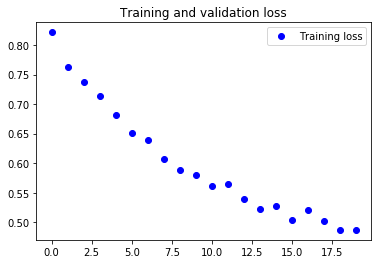

In [34]:
import matplotlib.pyplot as plt

#PLOT
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()